Set up environment

In [1]:
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd
import seaborn as sns
sns.set_style("white")

In [2]:
import sys
sys.path.append('/Users/zeynepenkavi/Dropbox/RangelLab/NeuralMassModels/helpers')
from eGLM_model import default_args, generateStructuralNetwork, generateSynapticNetwork, networkModel
from eGLM_helpers import phi, make_stimtimes
from multregconn import multregconn

Importing eGLM helpers...
All eGLM helpers imported!


# Make network

In [3]:
sim_args = copy(default_args)
sim_args.update({'W': np.array([[-.5, .2, 0], [.4, -.5, 0], [0, .3, -.5]]),
                'nodespercommunity': 1,
                'noise': 1, 
                'noise_scale': 1,
                'Tmax': 512})
sim_args

{'alternate_stim_nodes': 0,
 'bottomup': False,
 'dt': 0.5,
 'g': 1,
 'hubnetwork_dsity': 0.25,
 'I': None,
 'innetwork_dsity': 0.6,
 'local_com': 1,
 'ncommunities': 3,
 'noise': 1,
 'noise_loc': 0,
 'noise_scale': 1,
 'nodespercommunity': 1,
 'outnetwork_dsity': 0.08,
 'plot_network': False,
 'plot_task': False,
 's': 0.8,
 'showplot': False,
 'standardize': False,
 'stim_mag': 0.5,
 'stimsize': 3,
 'taskdata': None,
 'tasktiming': None,
 'tau': 1,
 'Tmax': 512,
 'topdown': True,
 'W': array([[-0.5,  0.2,  0. ],
        [ 0.4, -0.5,  0. ],
        [ 0. ,  0.3, -0.5]])}

Text(50.0, 0.5, 'To')

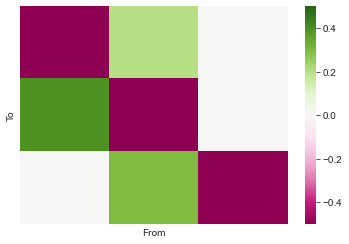

In [4]:
sns.heatmap(sim_args['W'], vmin = -0.5, vmax = 0.5, cmap="PiYG", xticklabels=False, yticklabels=False)
plt.xlabel("From")
plt.ylabel("To")

# Generate time series

## Resting

Resting data in this case is only noise not an AR(1) process.

In [5]:
rest_data, _ = networkModel(sim_args['W'], args_dict=sim_args)

In [6]:
rest_data_df = pd.DataFrame(rest_data)
rest_data_df['node_num'] = rest_data_df.index
rest_data_df = rest_data_df.melt(id_vars = ['node_num'])
rest_data_df['node_num'] = rest_data_df["node_num"].astype('category')
rest_data_df = rest_data_df.rename(columns={"variable": "time", "value": "activity"})

<AxesSubplot:xlabel='time', ylabel='activity'>

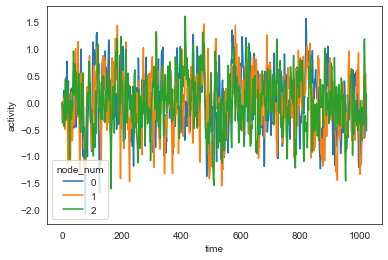

In [7]:
sns.lineplot(data=rest_data_df, x="time", y="activity", hue="node_num")

## Task

### Task 1: Long, infrequent, single (hub) node


In [8]:
sim_args.update({'on_len':64, 'off_len':32, 'stim_nodes': [1]})
tasktiming, stimtimes = make_stimtimes(stim_nodes= sim_args['stim_nodes'], args_dict=sim_args)
# plt.plot(tasktiming[::int(1/sim_args['dt'])])

In [9]:
sim_args.update({'I':stimtimes, 
                'noise': 1,
                'noise_scale': .2})
task1_data, _ = networkModel(sim_args['W'], args_dict=sim_args)

<AxesSubplot:xlabel='time', ylabel='activity'>

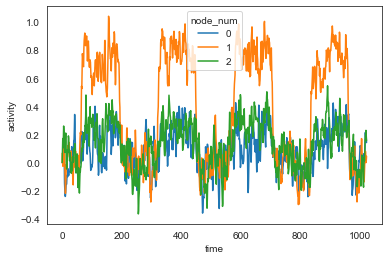

In [10]:
task1_data_df = pd.DataFrame(task1_data)
task1_data_df['node_num'] = task1_data_df.index
task1_data_df = task1_data_df.melt(id_vars = ['node_num'])
task1_data_df['node_num'] = task1_data_df["node_num"].astype('category')
task1_data_df = task1_data_df.rename(columns={"variable": "time", "value": "activity"})
sns.lineplot(data=task1_data_df, x="time", y="activity", hue="node_num")

### Task 2: Short, frequent, single (hub) node


In [11]:
sim_args.update({'on_len':16, 'off_len':8})
tasktiming, stimtimes = make_stimtimes(stim_nodes = sim_args['stim_nodes'], args_dict=sim_args)
# plt.plot(tasktiming[::int(1/sim_args['dt'])])

In [12]:
sim_args.update({'I':stimtimes, 
                'noise': 1,
                'noise_scale': .2})
task2_data, _ = networkModel(sim_args['W'], args_dict=sim_args)

<AxesSubplot:xlabel='time', ylabel='activity'>

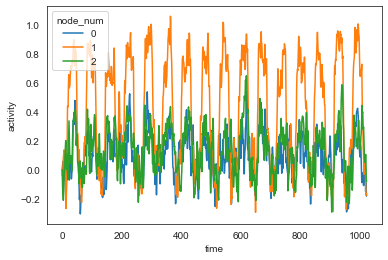

In [13]:
task2_data_df = pd.DataFrame(task2_data)
task2_data_df['node_num'] = task2_data_df.index
task2_data_df = task2_data_df.melt(id_vars = ['node_num'])
task2_data_df['node_num'] = task2_data_df["node_num"].astype('category')
task2_data_df = task2_data_df.rename(columns={"variable": "time", "value": "activity"})
sns.lineplot(data=task2_data_df, x="time", y="activity", hue="node_num")


### Task 3: Short, frequent, alternating nodes

Keep the previous task timing but change the stim node to be a different one for 5 cycles each

In [14]:
sim_args.update({'alternate_stim_nodes':1,
                'stim_nodes': [0,1,2]})
tasktiming, stimtimes = make_stimtimes(stim_nodes = sim_args['stim_nodes'], args_dict=sim_args)
# for i in range(len(stimtimes)):
#     plt.plot(stimtimes[i])

In [15]:
sim_args.update({'I':stimtimes, 
                'noise': 1,
                'noise_scale': .2})
task3_data, _ = networkModel(sim_args['W'], args_dict=sim_args)

<AxesSubplot:xlabel='time', ylabel='activity'>

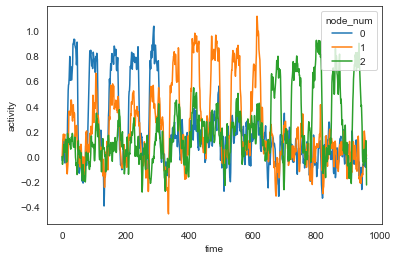

In [16]:
task3_data_df = pd.DataFrame(task3_data)
task3_data_df['node_num'] = task3_data_df.index
task3_data_df = task3_data_df.melt(id_vars = ['node_num'])
task3_data_df['node_num'] = task3_data_df["node_num"].astype('category')
task3_data_df = task3_data_df.rename(columns={"variable": "time", "value": "activity"})
sns.lineplot(data=task3_data_df, x="time", y="activity", hue="node_num")

# Compute FC connectivity matrices

## Pearson


In [17]:
timeseries = [rest_data, task1_data, task2_data, task3_data]
pearson_fc = np.ndarray(len(timeseries), dtype=object)

for i, cur_data in enumerate(timeseries):
    pearson_fc[i] = np.corrcoef(cur_data)

Text(0.5, 1.0, 'Alternating short FC')

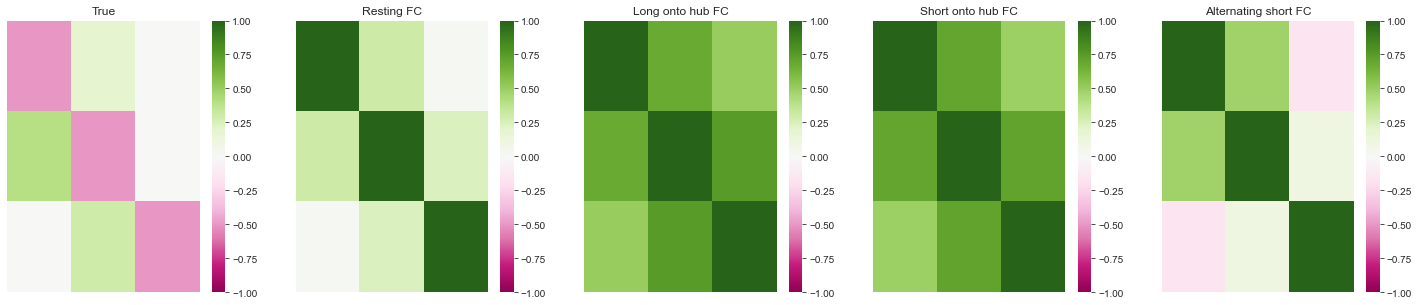

In [18]:
plt.rcParams["figure.figsize"][0] = 25
plt.rcParams["figure.figsize"][1] = 5
fig, a = plt.subplots(1, 5)

sns.heatmap(sim_args['W'], vmin = -1, vmax = 1, cmap="PiYG", xticklabels=False, yticklabels=False, ax = a[0])

for i, cur_fc in enumerate(pearson_fc):
    sns.heatmap(cur_fc, vmin = -1, vmax = 1, cmap="PiYG", xticklabels=False, yticklabels=False, ax=a[i+1])
    
a[0].set_title("True")
a[1].set_title("Resting FC")
a[2].set_title("Long onto hub FC")
a[3].set_title("Short onto hub FC")
a[4].set_title("Alternating short FC")

## Multiple regression

FC estimated by using the [multiple regression used by Cole et al.](https://github.com/ColeLab/ActflowToolbox/blob/master/connectivity_estimation/multregconn.py)

In [19]:
mreg_fc = np.ndarray(len(timeseries), dtype=object)

for i, cur_data in enumerate(timeseries):
    mreg_fc[i] = multregconn(cur_data)

Text(0.5, 1.0, 'Alternating short FC')

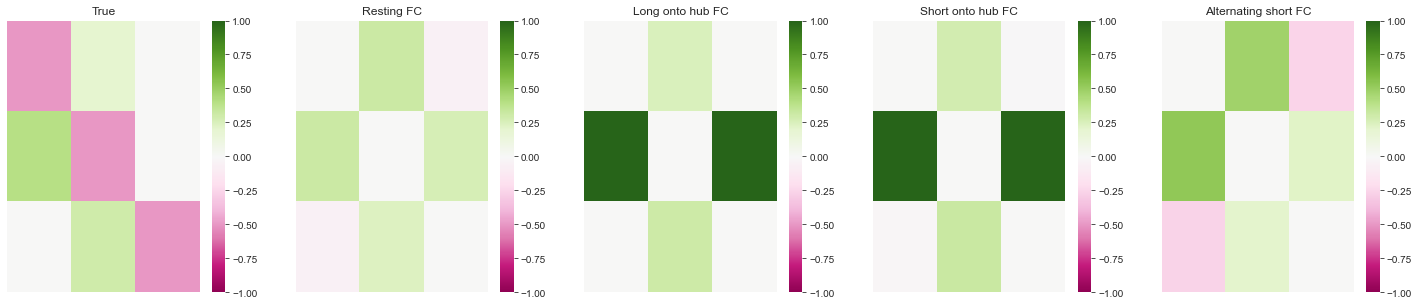

In [20]:
plt.rcParams["figure.figsize"][0] = 25
plt.rcParams["figure.figsize"][1] = 5
fig, a = plt.subplots(1, 5)

sns.heatmap(sim_args['W'], vmin = -1, vmax = 1, cmap="PiYG", xticklabels=False, yticklabels=False, ax = a[0])

for i, cur_fc in enumerate(mreg_fc):
    sns.heatmap(cur_fc, vmin = -1, vmax = 1, cmap="PiYG", xticklabels=False, yticklabels=False, ax=a[i+1])
    
a[0].set_title("True")
a[1].set_title("Resting FC")
a[2].set_title("Long onto hub FC")
a[3].set_title("Short onto hub FC")
a[4].set_title("Alternating short FC")